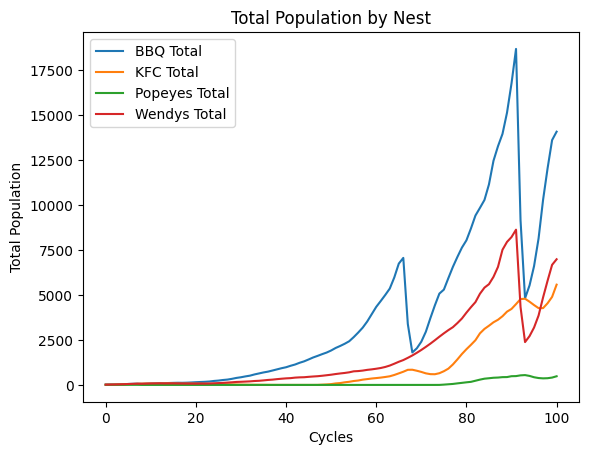

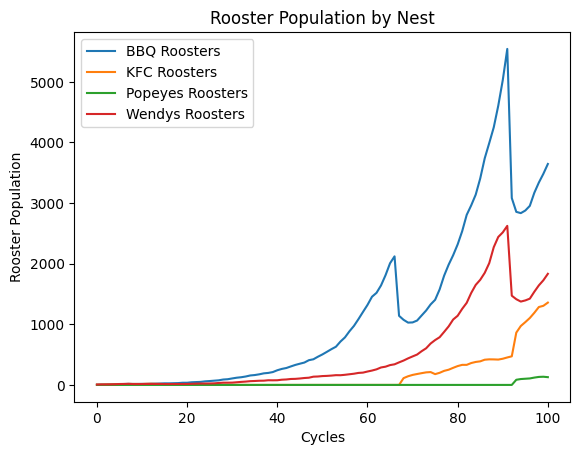

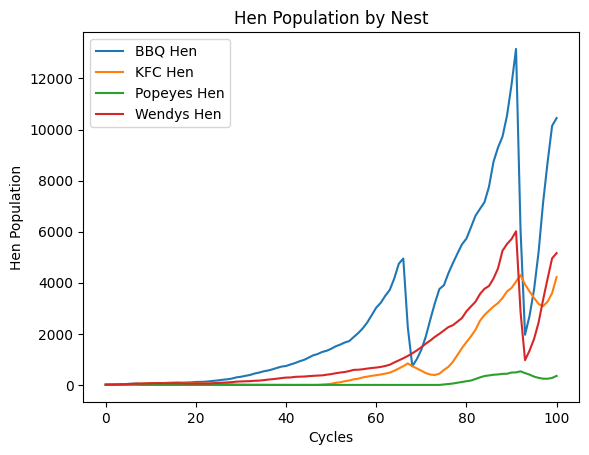

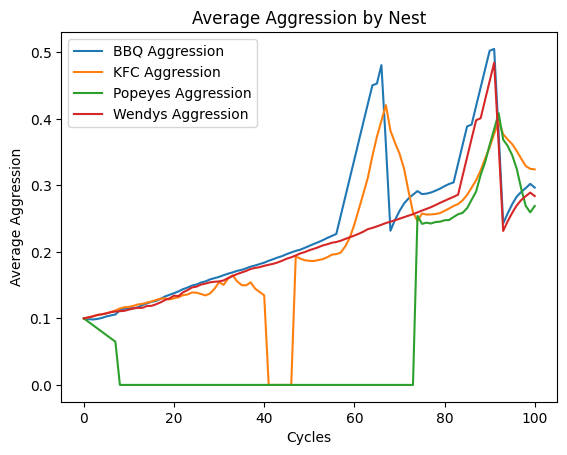

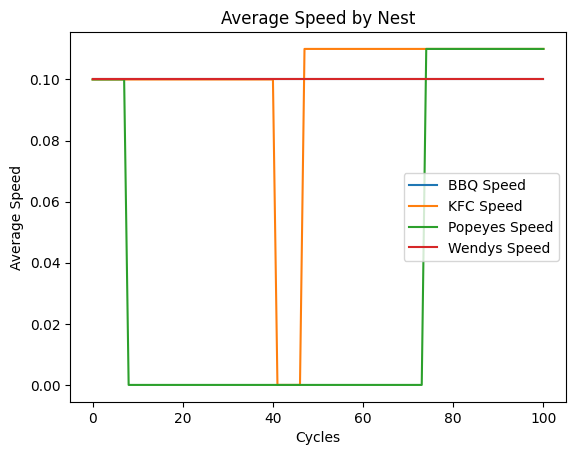

In [1]:
import sim
import matplotlib.pyplot as plt


nests = {
    "BBQ": {
        "nest"  : sim.Nest("BBQ", 2000, 20)
        , "roads" : [("KFC",0.40)]
    }
    , "KFC": {
            "nest"  : sim.Nest("KFC", 5000, 10)
        , "roads" : [("BBQ",0.40), ("Popeyes",0.70), ("Wendys",0.50)]
    }
    , "Popeyes": {
        "nest"  : sim.Nest("KFC", 3000, 5)
        , "roads" : [("KFC",0.70), ("Wendys", 0.30)]
    }
    , "Wendys": {
        "nest"  : sim.Nest("Wendys", 2500, 15)
        , "roads" : [("KFC", 0.50), ("Popeyes", 0.30)]
    }
    # Nest template
    # ,  "": {
    #     "nest"  : Nest("", , )
    #   , "roads" : [("", 0.)]
    # }
}

# Go through nests and create the world
for nest in nests:
    for n, d in nests[nest]["roads"]:
        nests[nest]["nest"].createRoad(n, d)

# Simulated the world
for i in range(sim.cycles):

    # Simulate all the nests for this cycle
    for nest in nests:
        nests[nest]["nest"].simulateCycle()
    
    # Move around the travelers
    for nest in nests:
        tr = nests[nest]["nest"].getTravelers()
        if tr["gender"] == "male":
            while len(tr["chickens"]) > 0:
                ch = tr["chickens"].pop()
                nests[ch["nest"]]["nest"].roosters.append(ch["chicken"])
        else:
            while len(tr["chickens"]) > 0:
                ch = tr["chickens"].pop()
                nests[ch["nest"]]["nest"].hens.append(ch["chicken"])
        


# Assigned a figure number to each data point
total = 1
roosters = 2
hens = 3
aggression = 4
speed = 5

# Plots the chart data.
x = list(range(0, sim.cycles + 1))
for nest in nests:
    plt.figure(total)
    plt.plot(x, nests[nest]["nest"].data.tData, label=f"{nest} Total")        
    plt.figure(roosters)
    plt.plot(x, nests[nest]["nest"].data.rData, label=f"{nest} Roosters")        
    plt.figure(hens)
    plt.plot(x, nests[nest]["nest"].data.hData, label=f"{nest} Hen")        
    plt.figure(aggression)
    plt.plot(x, nests[nest]["nest"].data.agAve, label=f"{nest} Aggression")
    plt.figure(speed)
    plt.plot(x, nests[nest]["nest"].data.spAve, label=f"{nest} Speed")

# Template for future plots
# plt.figure(total)
# plt.legend()
# plt.xlabel("")
# plt.ylabel("")
# plt.title("")

# Total population axis/title label
plt.figure(total)
plt.legend()
plt.xlabel("Cycles")
plt.ylabel("Total Population")
plt.title("Total Population by Nest")

# Rooster population axis/title label
plt.figure(roosters)
plt.legend()
plt.xlabel("Cycles")
plt.ylabel("Rooster Population")
plt.title("Rooster Population by Nest")

# Hen population axis/title label
plt.figure(hens)
plt.legend()
plt.xlabel("Cycles")
plt.ylabel("Hen Population")
plt.title("Hen Population by Nest")

# Average aggression axis/title label
plt.figure(aggression)
plt.legend()
plt.xlabel("Cycles")
plt.ylabel("Average Aggression")
plt.title("Average Aggression by Nest")

# Average speed axis/title label
plt.figure(speed)
plt.legend()
plt.xlabel("Cycles")
plt.ylabel("Average Speed")
plt.title("Average Speed by Nest")

# Show the plots
plt.show()